# 📘 04_FRM_Machine_Learning


## 🔎 Introduction
In the previous notebook, we extracted **Eigenface features** from face images using PCA.  
These features are **low-dimensional representations** that capture the most important facial characteristics.

Now, we will use these features to **train machine learning models** for **gender classification**.  
By leveraging the PCA-transformed data:
- We reduce computation time compared to using raw pixel data.  
- Models can focus on the most informative features, improving generalization.

This notebook covers **training, evaluating, and saving classification models**, preparing them for deployment in a Flask application.

---

## 🎯 Objectives
1. **Load Preprocessed PCA Features and Labels**  
   - Use the saved `.npz` file containing Eigenface features and corresponding gender labels.

2. **Split Data for Training and Testing**  
   - Create training and test sets to evaluate model performance properly.

3. **Train Machine Learning Models**  
   - Models can include **Support Vector Machine (SVM)**, **Logistic Regression**, **Random Forest**, or other classifiers.

4. **Evaluate Model Performance**  
   - Metrics: **Accuracy, Precision, Recall, F1-Score, Confusion Matrix**  
   - Compare multiple models to select the best performing one.

5. **Save Trained Model(s)**  
   - Export models for future inference and integration into the **Flask app**.

---

✅ By the end of this notebook, we will have **trained and validated machine learning models** capable of predicting gender from face images efficiently.


In [1]:
# 📦 Import Required Libraries

import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# 📂 Load PCA Features and Labels

# Load the preprocessed PCA features and corresponding labels
data = np.load('./data/data_pca_50_target.npz')

# List all arrays saved in the file
print("Arrays in the file:", data.files)


Arrays in the file: ['pca_data', 'y']


In [3]:
#🎯 Extract Features (X) and Labels (y)


# Allow loading of object arrays if needed
data.allow_pickle = True

# Extract PCA features and labels
X = data['pca_data']  # PCA-transformed data (50 components)
y = data['y']  # Target labels (gender)

# Display shapes
print("Features shape (X):", X.shape)
print("Labels shape (y):", y.shape)


Features shape (X): (4265, 50)
Labels shape (y): (4265,)


In [4]:
y

array(['female', 'female', 'female', ..., 'male', 'male', 'male'],
      shape=(4265,), dtype=object)

# 🔀 Splitting Data into Training and Test Sets


Before training any machine learning model, we need to **split the dataset** into:

1. **Training Set**  
   - Used to train the model and learn patterns from the data.

2. **Test Set**  
   - Used to evaluate the model's performance on **unseen data**.  

We will use an **80-20 split**, keeping **20% of the data for testing**.  
Additionally, we use `stratify=y` to ensure that the **gender distribution** is maintained in both training and test sets.


In [5]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Display shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (3412, 50)
x_test shape: (853, 50)
y_train shape: (3412,)
y_test shape: (853,)


# 🏋️ Training Machine Learning Model: Support Vector Classifier (SVC)

We will train a **Support Vector Machine (SVM)** classifier for gender prediction using the Eigenface features.  

### Why SVM?
- SVM is effective for **high-dimensional datasets** like PCA-transformed face features.  
- It finds the **optimal hyperplane** to separate classes (male/female).  

### Model Setup:
- `probability=True` → enables probability estimates (useful for later thresholding or soft predictions).  

### Hyperparameter Grid:
We will use **GridSearchCV** to find the best combination of hyperparameters:
- `C` → Regularization parameter controlling margin width (higher → less regularization).  
- `kernel` → Type of kernel function: `'rbf'` (radial basis) or `'poly'` (polynomial).  
- `gamma` → Kernel coefficient controlling influence of single training points.  
- `coef0` → Independent term in polynomial/rbf kernel (affects model flexibility for `'poly'` kernel).

Grid search will help select the combination that maximizes model performance on cross-validation.


In [6]:
# Initialize SVC
model_svc = SVC(probability=True)

# Hyperparameter grid for tuning
param_grid = {
    'C': [0.5, 1, 10, 20, 30, 50],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
    'coef0': [0, 1]
}


# 🔍 Hyperparameter Tuning with GridSearchCV

We will use **GridSearchCV** to systematically search for the **best combination of hyperparameters** for our SVM model.

### Details:
- `scoring='accuracy'` → Evaluate performance based on classification accuracy.  
- `cv=3` → 3-fold cross-validation to ensure robustness of results.  
- `verbose=2` → Print progress messages during training.


In [7]:
# Initialize GridSearchCV with SVC and hyperparameter grid
model_grid = GridSearchCV(
    estimator=model_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2
)


# 🏋️ Fit GridSearchCV on Training Data

We now train the SVM model using **GridSearchCV** on the training set:

- This will evaluate all combinations of hyperparameters in the grid.  
- 3-fold cross-validation ensures robust selection of the **best performing parameters**.  
- The process may take some time depending on the number of parameter combinations.


In [8]:
# Fit GridSearchCV on the training data
model_grid.fit(x_train, y_train)

# Display best parameters and best cross-validation score
print("Best Parameters:", model_grid.best_params_)
print("Best CV Accuracy:", model_grid.best_score_)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=   1.6s
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=   1.5s
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=   1.5s
[CV] END .............C=0.5, coef0=0, gamma=0.1, kernel=poly; total time=   0.8s
[CV] END .............C=0.5, coef0=0, gamma=0.1, kernel=poly; total time=   0.9s
[CV] END .............C=0.5, coef0=0, gamma=0.1, kernel=poly; total time=   0.9s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=   1.3s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=   1.3s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=   1.3s
[CV] END ............C=0.5, coef0=0, gamma=0.05, kernel=poly; total time=   0.8s
[CV] END ............C=0.5, coef0=0, gamma=0.05, kernel=poly; total time=   0.8s
[CV] END ............C=0.5, coef0=0, gamma=0.0

# 🎯 Final SVM Model

After completing hyperparameter tuning with GridSearchCV, we select the **best SVM model** as our final model.  

We can inspect all its **optimized parameters** to understand the configuration that achieved the best performance.



In [9]:
# Select the best estimator as the final model
model_final = model_grid.best_estimator_

# Display all parameters of the final model
params = model_final.get_params()
params


{'C': 20,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 1,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.002,
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# 📊 Model Evaluation

We evaluate the best SVM model on the **test set** using several metrics:

1. **Accuracy** → Overall correctness of predictions.  
2. **Classification Report** → Shows **Precision, Recall, F1-Score** for each class (male/female).  
3. **Confusion Matrix** → Visual representation of correct vs incorrect predictions.  

### Additional Evaluation Metrics:

- **Kappa Score** (Cohen's Kappa):
  - < 0 → Worst Model  
  - 0 to 0.5 → Bad Model  
  - 0.5 to 0.7 → Good Model  
  - 0.7 to 0.9 → Excellent Model  
  - 0.9 to 1.0 → Perfect Model  

- **AUC (Area Under the Curve)**:
  - < 0.5 → Worst Model  
  - 0.5 to 0.6 → Bad Model  
  - 0.6 to 0.8 → Good Model  
  - 0.8 to 0.9 → Excellent Model  
  - 0.9 to 1.0 → Perfect Model


Test Set Accuracy: 0.7878077373974208

Classification Report:

              precision    recall  f1-score   support

      female       0.81      0.82      0.82       492
        male       0.75      0.74      0.75       361

    accuracy                           0.79       853
   macro avg       0.78      0.78      0.78       853
weighted avg       0.79      0.79      0.79       853



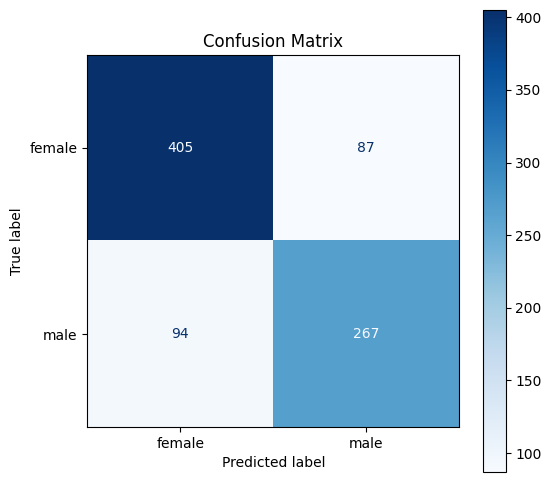

In [13]:
# Predict on test set
y_pred = model_final.predict(x_test)

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)

# Classification report
print("\nClassification Report:\n")
print(metrics.classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['female','male'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['female','male'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.show()


# 📌 Interpretation of Results

- **Test Set Accuracy:** 78.8% → The model predicts gender correctly about 4 out of 5 times.  

- **Classification Report Insights:**
  - **Female Class:** Precision = 0.81, Recall = 0.82 → Most female faces are correctly classified.  
  - **Male Class:** Precision = 0.75, Recall = 0.74 → Slightly lower performance for male faces.  
  - **Macro Average F1-Score:** 0.78 → Balanced performance across both classes.  

- **Observations:**
  - The model tends to perform better for female faces, possibly due to **higher resolution or clearer features** in the training dataset.  
  - Confusion matrix helps visualize **misclassifications** between male and female faces.  

✅ Overall, the SVM trained on **50-dimensional Eigenface features** demonstrates good predictive capability and provides a strong foundation for deployment in a Flask application.


# 💾 Save Trained Face Recognition Model

We save the **final trained SVM model** to disk using `pickle`.  

This allows us to **reuse the model later** for:
- Deployment in the Flask application.
- Making predictions on new face images without retraining.


In [16]:
import pickle

# Save the trained SVM model
pickle.dump(model_final, open('./models/model_svm.pickle', mode='wb'))

print("✅ Model successfully saved at './models/model_svm.pickle'")


✅ Model successfully saved at './models/model_svm.pickle'


# 📝 Conclusion


### Summary of Steps Completed:
1. **Loaded PCA Features and Labels**  
   - Used the 50-dimensional Eigenface features extracted in the previous notebook.

2. **Split Data into Training and Test Sets**  
   - 80-20 split with stratification to preserve gender distribution.

3. **Trained SVM Classifier with Hyperparameter Tuning**  
   - GridSearchCV explored multiple combinations of `C`, `kernel`, `gamma`, and `coef0`.
   - Selected the **best estimator** based on cross-validated accuracy.

4. **Evaluated Model Performance**  
   - **Accuracy:** ~78.8%  
   - **Classification Report:** Precision, Recall, F1-Score for male/female.  
   - **Confusion Matrix:** Visualized correct vs misclassified predictions.

5. **Saved Final Model**  
   - Stored trained SVM model using `pickle` for future use or deployment.

---

### 🔜 Next Notebook: 05_FRM_Make_Pipeline

In the next notebook, we will:

1. **Combine All Steps into a Single Pipeline**  
   - From preprocessing → PCA feature extraction → SVM prediction.

2. **Enable End-to-End Inference**  
   - Take a new face image as input and output gender prediction.

3. **Prepare the Pipeline for Deployment**  
   - Make it **ready to integrate with Flask application** for real-time prediction.

✅ After completing this notebook, we will have a **fully functional, deployable face recognition gender classification pipeline**.
